# Time Series Analysis (ISK-USD exchange rate forecasting)

## Goal:
Using ISK-USD daily exchange rate in the past 2 years (04. April 2023 - 04. April 2025 Daily rate) to predict exchange rate after two years.

## Method:
Use LSTM and CNN models (details see below)

## Process overview:
0. data preparation
1. split data into train and test data
2. fit model on train data
3. evaluate model using test data
4. use model to make prediction

## Data (Central Bank of Iceland):
https://cb.is/statistics/official-exchange-rate/?timeseries=4055&d_from=2023-04-04&d_to=2025-04-04&chart=1&date=2025-04-04&m_from=2024-04-04&y_from=2015&m_to=2025-03-31&y_to=2024#tab-12276c86-1823-49c9-b46e-cdccdfdbee1b



In [ ]:
# Import libraries

import pandas as pd
from datetime import timedelta
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from statsmodels.tsa.stattools import adfuller


### Data preparation

In [ ]:
# Load Exchange Rate Data
uploaded = files.upload()

for filename in uploaded:
  df = pd.read_csv(filename, sep=';')
  df = df.iloc[:, :-1]
  print(df.head())

Saving timeseries_byday_20230404_20250404.csv to timeseries_byday_20230404_20250404 (4).csv
         Date  US Dollar USD mid
0  04.04.2025             130.87
1  03.04.2025             130.40
2  02.04.2025             133.02
3  01.04.2025             133.20
4  31.03.2025             131.95


In [ ]:
# Convert Date to datetime objects and set it as the index.
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df.set_index('Date', inplace=True)

# Ensure the dataframe is sorted by date.
df = df.sort_index()
print(df.head())
print(df.tail())

            US Dollar USD mid
Date                         
2023-04-04             136.96
2023-04-05             136.84
2023-04-11             137.09
2023-04-12             136.51
2023-04-13             135.36
            US Dollar USD mid
Date                         
2025-03-31             131.95
2025-04-01             133.20
2025-04-02             133.02
2025-04-03             130.40
2025-04-04             130.87


### Stationary test
To see if there are unit roots in the time series. This step is not necessary for LSTM and CNN model, because they can handle non-stationary series without differencing.
(DOI:10.1109/ICCCNT45670.2019.8944624)

In [ ]:
def adf_test(series, significance_level=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test for stationarity.

    """

    result = adfuller(series)
    adf_statistic = result[0]
    p_value = result[1]

    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)

    if p_value < significance_level:
        print("The series is stationary.")
        is_stationary = True
    else:
        print("The series is non-stationary.")
        is_stationary = False

adf_test(df['US Dollar USD mid'])

ADF Statistic: -2.2530375485027636
p-value: 0.18756167259871398
The series is non-stationary.


### Long Short-Term Memory (LSTM)

LSTMs are designed to capture long-term dependencies. Using a time_step of 60 (approximately two months of daily data) to capture these longer-term patterns.

Model has three layers, each layers has 50 neurons.

Loss function: MSE

Use Adam (Adaptive Moment Estimation) calculates learning rates for each parameter to adjust the model's parameters (weights and biases) during training to minimize the loss function.

In [ ]:
# Preprocess Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['US Dollar USD mid'].values.reshape(-1, 1))

def create_dataset(dataset, time_step=30):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset(scaled_data)
X = X.reshape(X.shape[0], X.shape[1], 1)


In [ ]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size, :], X[train_size:len(X), :]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [ ]:
# Train Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=60, batch_size=64, verbose=1)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.2180
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0370
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0249
Epoch 4/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0217
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0198
Epoch 6/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0179
Epoch 7/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0174
Epoch 8/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0164
Epoch 9/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0131
Epoch 10/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0139
Epoch 11/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0145
Epoch 12/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0131
Epoch 13/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0139
Epoch 14/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0125
Epoch 15/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0109
Epoch 16/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/

In [ ]:
# Predictions on test set.
test_predictions = model.predict(X_test)

# Inverse transform predictions and actual values.
test_predictions_original = scaler.inverse_transform(test_predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step


In [ ]:
# Calculate evaluation metrics.
rmse = np.sqrt(mean_squared_error(y_test_original, test_predictions_original))
mae = np.mean(np.abs(y_test_original - test_predictions_original))
r2 = r2_score(y_test_original, test_predictions_original)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 1.084324478725119
MAE: 0.8645943174970923
R-squared: 0.8546518919059449


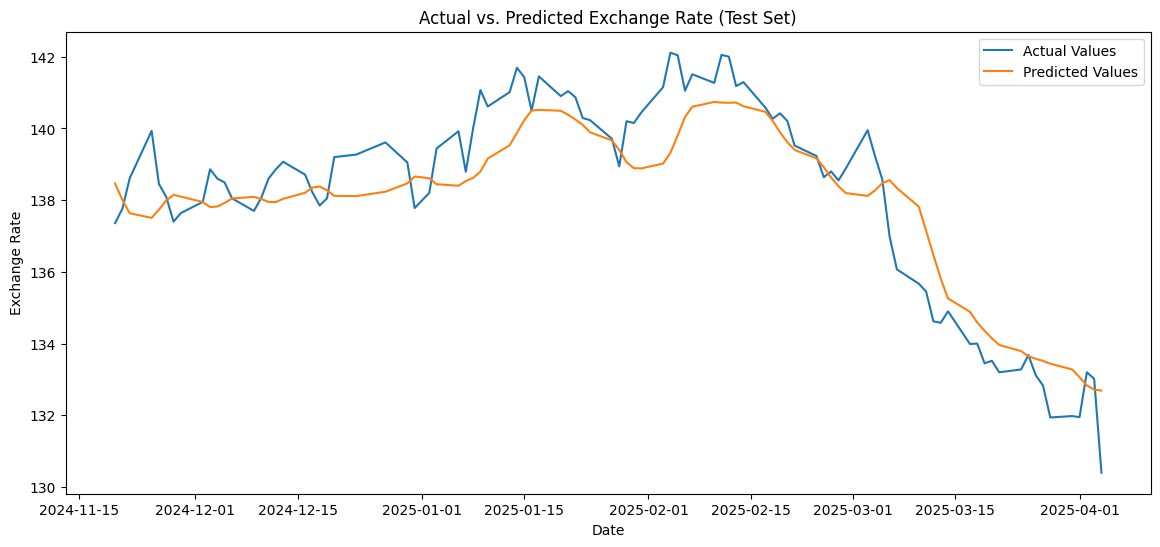

In [ ]:
# Plot the predictions vs. actual values
time_step=30

plt.figure(figsize=(14, 6))
plt.plot(df.index[len(X_train)+time_step+1:], y_test_original, label='Actual Values')
plt.plot(df.index[len(X_train)+time_step+1:], test_predictions_original, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Actual vs. Predicted Exchange Rate (Test Set)')
plt.legend()
plt.show()

In [ ]:
# Two-Year Prediction
future_days = 365 * 2
prediction_list = scaled_data[-30:].tolist()  # Last 30 days as initial input

for _ in range(future_days):
    x_input = np.array(prediction_list[-30:]).reshape((1, 30, 1))
    y_predict = model.predict(x_input)
    prediction_list.append(y_predict[0].tolist())

prediction_list = prediction_list[30:]  # Remove initial 30 days

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

In [ ]:
# Inverse Transform
predictions = scaler.inverse_transform(np.array(prediction_list).reshape(-1, 1))

# Create Date Range
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=x) for x in range(1, future_days + 1)]

# Create a dataframe of the predictions.
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Rate': predictions.flatten()})
future_df.set_index('Date', inplace=True)

# Display prediction after 2 years.
last_day_prediction = future_df.iloc[-1]['Predicted Rate']
last_day = future_df.index[-1]
print(f"Prediction for {last_day.strftime('%d-%m-%Y')}: {last_day_prediction}")

Prediction for 04-04-2027: 136.9502082824707


### CNN (Convolutional Neural Network)

CNNs, on the other hand, are better at capturing local patterns. They use convolutional filters to extract features from small windows of the time series.

Loss function: MSE

Use Adam (Adaptive Moment Estimation) calculates learning rates for each parameter to adjust the model's parameters (weights and biases) during training to minimize the loss function.

In [ ]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['US Dollar USD mid'].values.reshape(-1, 1))

def create_dataset(dataset, time_step=10):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 10
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)


In [ ]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size, :], X[train_size:len(X), :]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [ ]:
# Train Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1544
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 
Epoch 9/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 
Epoch 10/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 
Epoch 11/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 
Epoch 12/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 
Epoch 13/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 
Epoch 14/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 
Epoch 15/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 
Epoch 16/60
13/1

In [ ]:
# Predictions on test set.
test_predictions = model.predict(X_test)

# Inverse transform predictions and actual values.
test_predictions_original = scaler.inverse_transform(test_predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [ ]:
# Calculate evaluation metrics.
rmse = np.sqrt(mean_squared_error(y_test_original, test_predictions_original))
mae = np.mean(np.abs(y_test_original - test_predictions_original))
r2 = r2_score(y_test_original, test_predictions_original)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 0.8361646810164203
MAE: 0.6415077116051499
R-squared: 0.9103387280360403


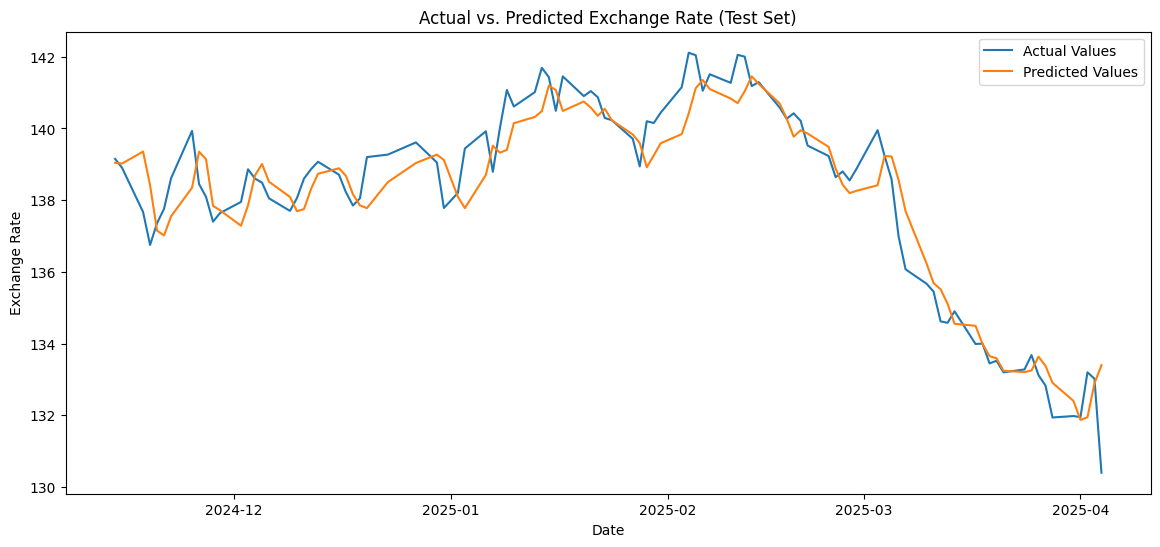

In [ ]:
# Plot the predictions vs. actual values
plt.figure(figsize=(14, 6))
plt.plot(df.index[len(X_train)+time_step+1:], y_test_original, label='Actual Values')
plt.plot(df.index[len(X_train)+time_step+1:], test_predictions_original, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Actual vs. Predicted Exchange Rate (Test Set)')
plt.legend()
plt.show()

In [ ]:
# Two-Year Prediction
future_days = 365 * 2
prediction_list = scaled_data[-10:].tolist()  # Last 10 days as initial input

for _ in range(future_days):
    x_input = np.array(prediction_list[-10:]).reshape((1, 10, 1))
    y_predict = model.predict(x_input)
    prediction_list.append(y_predict[0].tolist())

prediction_list = prediction_list[10:]  # Remove initial 10 days

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [ ]:
# Inverse Transform
predictions = scaler.inverse_transform(np.array(prediction_list).reshape(-1, 1))

# Create Date Range
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=x) for x in range(1, future_days + 1)]

# Create a dataframe of the predictions.
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Rate': predictions.flatten()})
future_df.set_index('Date', inplace=True)

last_day_prediction = future_df.iloc[-1]['Predicted Rate']
last_day = future_df.index[-1]
print(f"Prediction for {last_day.strftime('%Y-%m-%d')}: {last_day_prediction}")

Prediction for 2027-04-04: 131.21964570879936


### Models comparison
1. in the test data, CNN capture more variance in the time series (R-squared = 0.91)
2. Both models get higher R-squared value than using ARIMA method (which usually get R-squared around 0.1-0.2)

### Forecasting

The prediction of ISK-USD exchange rate in 2027 april is 136.95 from LSTM model. However, the prediction of ISK-USD exchange rate in 2027 april is 131.21 from CNN model.

### Considerations

According to the current international situation and the US Tariff Policy, The flucturation may be difficult to predict, expecially in a long term period.

